# 🔬 Beijing Air Quality
## 📘 Notebook 11 – Advanced Regression & Hyperparameter Search

| Field         | Description                                        |
|:--------------|:---------------------------------------------------|
| Author:       |	Robert Steven Elliott                            |
| Course:       |	Code Institute – Data Analytics with AI Bootcamp |
| Project Type: |	Capstone                                         |
| Date:         |	December 2025                                    |

This project complies with the CC BY 4.0 licence by including proper attribution.


## Objectives

1. Multi-model regression benchmarking
    - Linear Regression
    - Decision Tree Regressor
    - Random Forest Regressor
    - AdaBoost Regressor
    - XGBoost Regressor
2. Hyperparameter search using GridSearchCV
3. Performance comparison (MAE, RMSE, R²)
4. Select the best model

## Citation  
This project uses data from:

Chen, Song (2017). *Beijing Multi-Site Air Quality.*  
UCI Machine Learning Repository — Licensed under **CC BY 4.0**.  
DOI: https://doi.org/10.24432/C5RK5G  
Kaggle mirror by Manu Siddhartha.

---

## Notebook Setup

### Import Required Libraries

(The following libraries support analysis, plotting, and data manipulation.)

In [1]:
import sys # system-level operations
import pandas as pd # data manipulation
import numpy as np # numerical operations
import matplotlib.pyplot as plt # plotting
import seaborn as sns # statistical data visualization
import plotly.express as px # interactive plotting
from pathlib import Path # filesystem paths
import json # JSON handling

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split # model selection
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score # model evaluation
from sklearn.linear_model import LinearRegression # linear regression model
from sklearn.tree import DecisionTreeRegressor # decision tree model
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor # ensemble models
from sklearn.preprocessing import OrdinalEncoder

from xgboost import XGBRegressor # XGBoost model
from pandas.api.types import CategoricalDtype # categorical data types
import joblib # model serialization
import warnings # warning control

### Ignore Warnings

In [2]:
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", message=".*is_categorical_dtype.*") # ignore specific deprecation warning
warnings.filterwarnings("ignore", message=".*is_sparse is deprecated.*") # ignore specific deprecation warning
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost") # ignore FutureWarnings from xgboost
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost.data") # ignore FutureWarnings from xgboost.data
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas") # ignore FutureWarnings from pandas

### Configure Visual Settings

In [3]:

plt.style.use("seaborn-v0_8") # set matplotlib style
sns.set_theme() # set seaborn theme

### Set Up Project Paths

In [4]:
PROJECT_ROOT = Path.cwd().parent # Assuming this script is in a subdirectory of the project root
DATA_PATH = PROJECT_ROOT / "data" # Path to the data directory
MODELS_PATH = PROJECT_ROOT / "models" # Path to save models
MODELS_PATH.mkdir(exist_ok=True) # Create models directory if it doesn't exist

sys.path.append(str(PROJECT_ROOT)) # Add project root to sys.path

FIGURES_PATH = PROJECT_ROOT / "figures" / "modelling" # Path to save figures
FIGURES_PATH.mkdir(parents=True, exist_ok=True) # Create directory if it doesn't exist
INPUT_PATH = DATA_PATH / "engineered" / "beijing_engineered.csv" # input file path
print("Input path :", INPUT_PATH) # Print input path

Input path : /home/robert/Projects/beijing-air-quality/data/engineered/beijing_engineered.csv


### include custom functions

In [5]:
from utils.feature_engineering import apply_forecasting_features # custom feature engineering function
from utils.load_csv import load_csv # custom data loading function

### Load Dataset

In [6]:
df = load_csv(INPUT_PATH) # Load cleaned data
# Freeze categories for season

season_dtype = CategoricalDtype(
    categories=sorted(df["season"].unique()),
    ordered=False
) # define categorical dtype
df["season"] = df["season"].astype(season_dtype) # convert to categorical
df["season"] = df["season"].cat.codes.astype("int16") # convert to integer codes

# Freeze area_type category order
area_dtype = CategoricalDtype(
    categories=sorted(df["area_type"].unique()),
    ordered=False
) # define categorical dtype
df["area_type"] = df["area_type"].astype(area_dtype) # convert to categorical
df["area_type"] = df["area_type"].cat.codes.astype("int16") # convert to integer codes

station_dtype = CategoricalDtype(
    categories=sorted(df["station"].unique()),
    ordered=False
) # define categorical dtype
df["station"] = df["station"].astype(station_dtype) # convert to categorical
df["station"] = df["station"].cat.codes.astype("int16") # convert to integer codes

# Save the frozen dtypes for Notebook 12 – Forecasting
joblib.dump(season_dtype, MODELS_PATH / "season_dtype.joblib")
joblib.dump(area_dtype, MODELS_PATH / "area_dtype.joblib")
joblib.dump(station_dtype, MODELS_PATH / "station_dtype.joblib")

print("Saved categorical dtypes for season & area_type.")

df["day_of_week"] = df["day_of_week"].astype(int) # Ensure day_of_week is integer

object_cols = df.select_dtypes(include="object").columns # Identify object columns
df.drop(columns=object_cols, axis="columns", inplace=True) # Drop object columns

df.head() # Display first few rows of the dataframe

Saved categorical dtypes for season & area_type.


,datetime,year,month,day,hour,pm25,temperature,pressure,dew_point,rain,...,season,day_of_week,hour_sin,hour_cos,month_sin,month_cos,dew_point_spread,temp_pres_interaction,rain_binary,relative_humidity
0,2013-03-01 00:00:00,2013,3,1,0,4.0,-0.7,1023.0,-18.8,0.0,...,1,4,0.000000,1.000000,1.0,6.123234e-17,18.1,-716.10,0,24.008842
1,2013-03-01 01:00:00,2013,3,1,1,8.0,-1.1,1023.2,-18.2,0.0,...,1,4,0.258819,0.965926,1.0,6.123234e-17,17.1,-1125.52,0,26.013678
2,2013-03-01 02:00:00,2013,3,1,2,7.0,-1.1,1023.5,-18.2,0.0,...,1,4,0.500000,0.866025,1.0,6.123234e-17,17.1,-1125.85,0,26.013678
3,2013-03-01 03:00:00,2013,3,1,3,6.0,-1.4,1024.5,-19.4,0.0,...,1,4,0.707107,0.707107,1.0,6.123234e-17,18.0,-1434.30,0,24.007753
4,2013-03-01 04:00:00,2013,3,1,4,3.0,-2.0,1025.2,-19.5,0.0,...,1,4,0.866025,0.500000,1.0,6.123234e-17,17.5,-2050.40,0,24.876783


## Data Overview Analysis

(Understanding structure, completeness, and variable types.)

### Structure + Missing Values

In [7]:
print("Dataframe Info:") # Display dataframe info
display(df.info()) # Display dataframe info
print("\nDataframe Shape:") # Display dataframe shape
display(df.shape) # Display dataframe shape
print("\nMissing Values:") # Check for missing values
display(df.isna().sum()) # Check for missing values

Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403776 entries, 0 to 403775
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   datetime               403776 non-null  datetime64[ns]
 1   year                   403776 non-null  int64         
 2   month                  403776 non-null  int64         
 3   day                    403776 non-null  int64         
 4   hour                   403776 non-null  int64         
 5   pm25                   403776 non-null  float64       
 6   temperature            403776 non-null  float64       
 7   pressure               403776 non-null  float64       
 8   dew_point              403776 non-null  float64       
 9   rain                   403776 non-null  float64       
 10  wind_direction         403776 non-null  category      
 11  wind_speed             403776 non-null  float64       
 12  station                40377

None


Dataframe Shape:


(403776, 26)


Missing Values:


datetime                 0
year                     0
month                    0
day                      0
hour                     0
pm25                     0
temperature              0
pressure                 0
dew_point                0
rain                     0
wind_direction           0
wind_speed               0
station                  0
latitude                 0
longitude                0
area_type                0
season                   0
day_of_week              0
hour_sin                 0
hour_cos                 0
month_sin                0
month_cos                0
dew_point_spread         0
temp_pres_interaction    0
rain_binary              0
relative_humidity        0
dtype: int64

## Select Modelling Features

We use all engineered features, including lags and rolling means.

In [8]:
target = "pm25" # Define target variable

drop_cols = [
    "latitude", "longitude",
    "pm25", "datetime", 
    "wind_direction"
]

feature_cols = [
    col for col in df.columns 
    if col not in drop_cols
] # Define feature columns excluding target and non-feature columns

X = df[feature_cols].dropna() # Features dataframe with missing values dropped
y = df.loc[X.index, "pm25"] # Target series aligned with features



## Train/Test Split (Time-Ordered)

In [9]:

df = df.sort_values("datetime") # Sort by datetime
train, test = train_test_split(df, test_size=0.2, random_state=42, shuffle=False) # Time-based train-test split

print("Train range:", train["datetime"].min(), "to", train["datetime"].max())
print("Test range :", test["datetime"].min(), "to", test["datetime"].max())

train = apply_forecasting_features(train, add_lags=True, add_rollings=True)
test  = apply_forecasting_features(test, add_lags=True, add_rollings=True)

print("Train shape:", train.shape)
print("Test shape:", test.shape)

train = train.dropna() # Drop rows with missing values in training set
test = test.dropna()  # Drop rows with missing values in testing set

print("Train shape after dropping NA:", train.shape)
print("Test shape after dropping NA:", test.shape)

Train range: 2013-03-01 00:00:00 to 2016-03-26 14:00:00
Test range : 2016-03-26 14:00:00 to 2016-12-31 23:00:00
Train shape: (323020, 35)
Test shape: (80756, 35)
Train shape after dropping NA: (262261, 35)
Test shape after dropping NA: (13424, 35)


In [10]:
features = [
    "temperature",
    "dew_point",
    "pressure",
    "rain",
    "wind_speed",
    "temp_pres_interaction",
    "dew_point_spread",
    "rain_binary",
    "area_type",
    "hour_sin",
    "hour_cos",
    "month_sin",
    "month_cos",
    "season",
    "day_of_week",
    "month",
    "year",
    "station",
    "relative_humidity",
    "pm25_lag_1h",
    "pm25_lag_3h",
    "pm25_lag_6h",
    "pm25_lag_12h",
    "pm25_lag_18h",
    "pm25_roll_3h_mean",
    "pm25_roll_6h_mean",
    "pm25_roll_12h_mean",
    "pm25_roll_18h_mean"
] # Define final feature set

In [11]:
X_train = train[features] # Training features
y_train = train["pm25"] # Training target

X_test = test[features] # Testing features
y_test = test["pm25"] # Testing target

In [12]:
# Encode categorical features as integer codes
for df_ in [X_train, X_test]:
    cat_cols = df_.select_dtypes(include=["category"]).columns
    for col in cat_cols:
        df_[col] = df_[col].cat.codes.astype("int16")

In [13]:
X_train = X_train.astype(float) # Ensure features are float
X_test = X_test.astype(float) # Ensure features are float

## Define Algorithms & Hyperparameter Grids

In [14]:
models_and_grids = {
    # Linear Regression
    "LinearRegression": {
        "model": LinearRegression(), # Linear Regression model
        "params": {
            "fit_intercept": [True, False] # Hyperparameter grid
        }
    }, 
    # Decision Tree Regressor
    "DecisionTree": {
        "model": DecisionTreeRegressor(random_state=42), # Decision Tree model
        "params": {
            "max_depth": [5, 10, 20], # maximum depth of the tree
            "min_samples_split": [2, 10, 20] # minimum number of samples required to split an internal node
        } 
    },
    # Random Forest Regressor
    "RandomForest": {
        "model": RandomForestRegressor(random_state=42, n_jobs=-1), # Random Forest model
        "params": {
            "n_estimators": [50, 100], # number of trees in the forest
            "max_depth": [10, 20], # maximum depth of the tree
            "max_features": ["sqrt", "log2"] # number of features to consider at each split
        }
    },
    # AdaBoost Regressor
    "AdaBoost": {
        "model": AdaBoostRegressor(random_state=42),
        "params": {
            "n_estimators": [50, 100], # number of weak learners
            "learning_rate": [0.5, 1.0] # learning rate shrinks the contribution of each weak learner
        }
    },
    # XGBoost Regressor
    "XGBoost": {
        "model": XGBRegressor(
            objective="reg:squarederror", # objective function for regression
            eval_metric="rmse", # evaluation metric
            random_state=42, # random seed for reproducibility
            n_estimators=200, # number of boosting rounds
            enable_categorical=False # disable native categorical handling
        ),
        "params": {
            "max_depth": [4, 6, 8], # maximum depth of a tree
            "learning_rate": [0.05, 0.1, 0.2], # step size shrinkage
            "subsample": [0.8, 1.0] # fraction of samples used for fitting the individual base learners
        }
    }
}


## GridSearchCV

In [15]:
results = [] # to store results

tscv = TimeSeriesSplit(n_splits=5) # time series cross-validation

# Iterate over models and their hyperparameter grids

for name, cfg in models_and_grids.items(): 
    print(f"\nRunning GridSearch for: {name}")  # Log current model

    grid = GridSearchCV(
        estimator=cfg["model"], # model to tune
        param_grid=cfg["params"], # hyperparameter grid
        scoring="neg_mean_squared_error", # evaluation metric
        refit=True, # refit best model
        cv=tscv, # cross-validation strategy
        n_jobs=-1, # use all available cores
        verbose=1 # verbosity level
    ) # Initialize GridSearchCV
    
    # Fit grid search
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning) # ignore FutureWarnings
        grid.fit(X_train, y_train) # Fit grid search

    best_model = grid.best_estimator_ # Get best model

    # Make predictions on test set
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning) # ignore FutureWarnings
        preds = best_model.predict(X_test) #
        
    results.append({
        "Model": name,
        "Best Params": grid.best_params_, # Store best hyperparameters
        "MAE": mean_absolute_error(y_test, preds), # Mean Absolute Error
        "RMSE": root_mean_squared_error(y_test, preds), # Root Mean Squared Error
        "R2": r2_score(y_test, preds), # R-squared
        "Estimator": best_model # Best estimator
    }) # Store results

results_df = pd.DataFrame(results) # Convert results to DataFrame
results_df  # Display results DataFrame


Running GridSearch for: LinearRegression
Fitting 5 folds for each of 2 candidates, totalling 10 fits

Running GridSearch for: DecisionTree
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Running GridSearch for: RandomForest
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Running GridSearch for: AdaBoost
Fitting 5 folds for each of 4 candidates, totalling 20 fits

Running GridSearch for: XGBoost
Fitting 5 folds for each of 18 candidates, totalling 90 fits


,Model,Best Params,MAE,RMSE,R2,Estimator
0,LinearRegression,{'fit_intercept': False},9.687846,16.037887,0.943242,LinearRegression(fit_intercept=False)
1,DecisionTree,"{'max_depth': 5, 'min_samples_split': 2}",9.852350,16.789541,0.937797,"DecisionTreeRegressor(max_depth=5, random_stat..."
2,RandomForest,"{'max_depth': 20, 'max_features': 'sqrt', 'n_e...",10.057711,16.431940,0.940418,"(DecisionTreeRegressor(max_depth=20, max_featu..."
3,AdaBoost,"{'learning_rate': 0.5, 'n_estimators': 50}",38.535454,45.844647,0.536218,"(DecisionTreeRegressor(max_depth=3, random_sta..."
4,XGBoost,"{'learning_rate': 0.05, 'max_depth': 4, 'subsa...",9.105732,15.438962,0.947402,"XGBRegressor(base_score=None, booster=None, ca..."


## Model Performance Visualisation

Understanding the performance of each model visually helps compare algorithms beyond raw metrics.

The following plots summarise model accuracy, generalisation behaviour, and error patterns.

### RMSE, MAE, and R² Comparison Across All Models

#### Purpose

This chart highlights the strengths and weaknesses of each model across the three key metrics.
It helps identify which algorithms consistently perform well — not just the final winner.

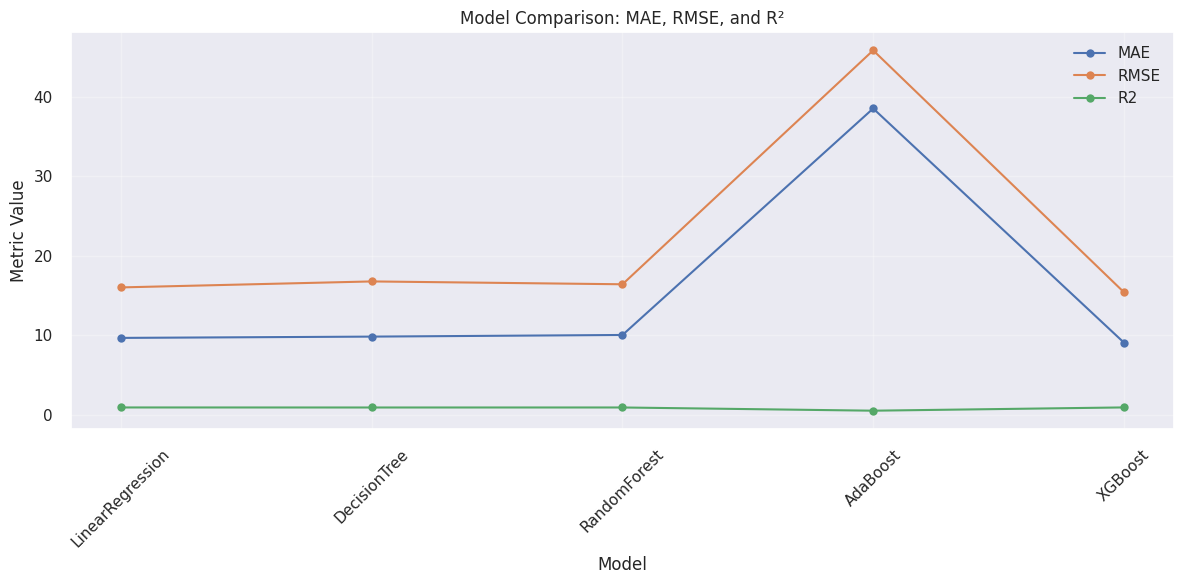

In [16]:
# Create performance comparison plot
metrics = ["MAE", "RMSE", "R2"] # metrics to plot

plt.figure(figsize=(12,6)) # Set figure size
# Plot each metric
for metric in metrics:
    plt.plot(results_df["Model"], 
             results_df[metric], #
             marker="o", 
             label=metric) # Plot each metric

plt.title("Model Comparison: MAE, RMSE, and R²") # Title
plt.xlabel("Model") # X-axis label
plt.ylabel("Metric Value") # Y-axis label
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.legend() # Show legend
plt.grid(alpha=0.3) # Add grid with transparency
plt.tight_layout() # Adjust layout to prevent clipping
plt.savefig(FIGURES_PATH / "model_performance_comparison.png") # Save the figure
plt.show() # Display the plot

### RMSE Bar Chart (Ranked Models)

#### Purpose

RMSE is often the most important metric in forecasting tasks because it penalises large errors.
This makes it the best indicator of real-world performance.

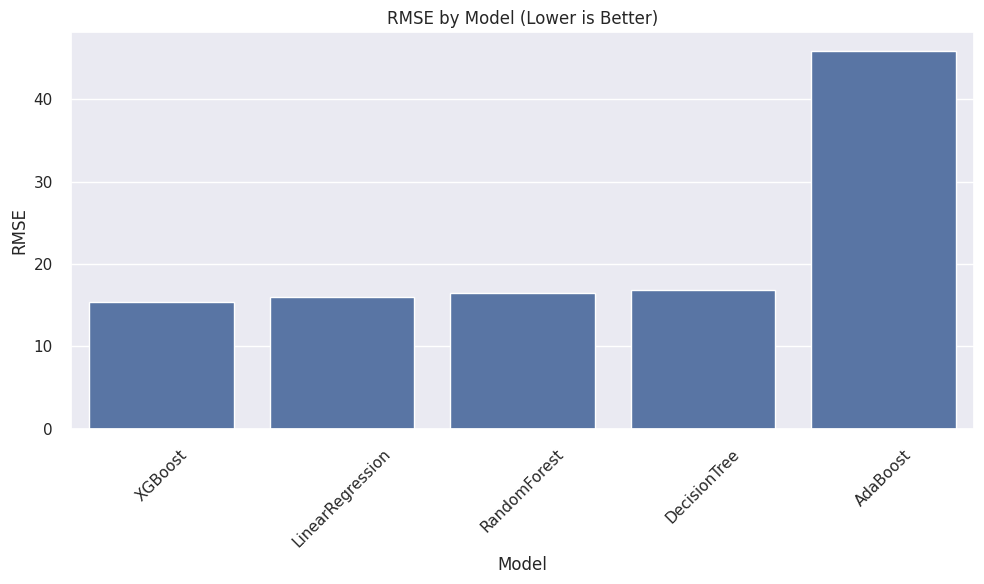

In [17]:
plt.figure(figsize=(10,6)) # Set figure size
sns.barplot(data=results_df.sort_values("RMSE"), 
            x="Model", 
            y="RMSE") # Bar plot of RMSE by model
plt.title("RMSE by Model (Lower is Better)") # Title
plt.ylabel("RMSE") # Y-axis label
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent clipping
plt.savefig(FIGURES_PATH / "rmse_ranked_models.png") # Save the figure
plt.show() # Display the plot

### Predicted vs Actual Plot (Best Model)

#### Purpose

Shows how closely the model's predictions match real PM2.5 values.

Strong alignment with the diagonal means good performance.

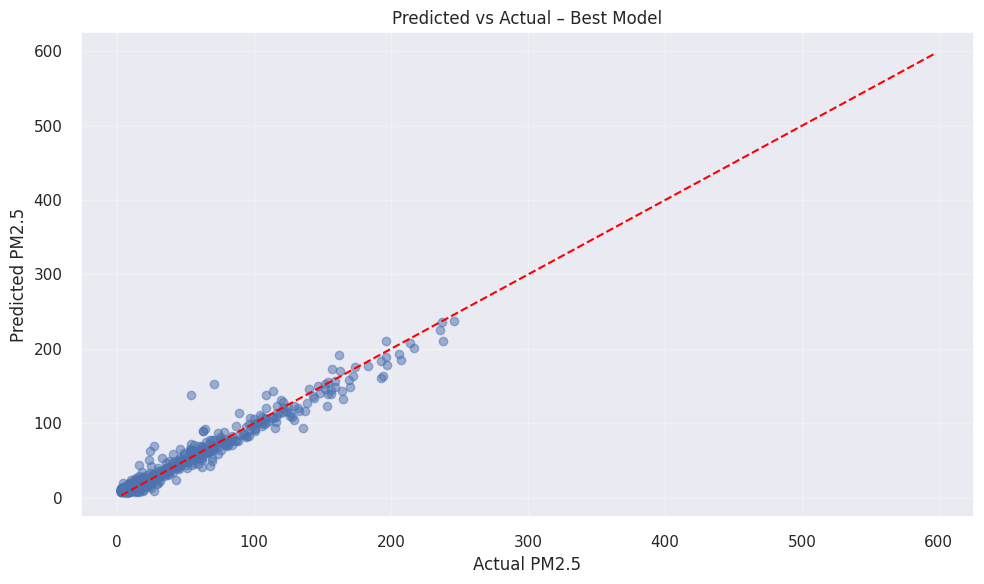

In [18]:
best_preds = best_model.predict(X_test) # Predictions from the best model

plt.figure(figsize=(10,6)) # Predicted vs Actual plot for the best model
plt.scatter(y_test[:500], best_preds[:500], alpha=0.5) # Plot first 500 points for clarity
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color="red", linestyle="--") # 45-degree line
plt.xlabel("Actual PM2.5") # X Labels
plt.ylabel("Predicted PM2.5") # Y Labels
plt.title("Predicted vs Actual – Best Model") # Title
plt.grid(alpha=0.3) # Grid with transparency
plt.tight_layout() # Adjust layout
plt.savefig(FIGURES_PATH / "predicted_vs_actual_best_model.png") # Save figure
plt.show() # Display plot


### Residual Distribution Plot

#### Purpose

Residuals (actual - predicted) reveal patterns such as model bias or non-linearity.

Well-performing models produce residuals centred around zero.

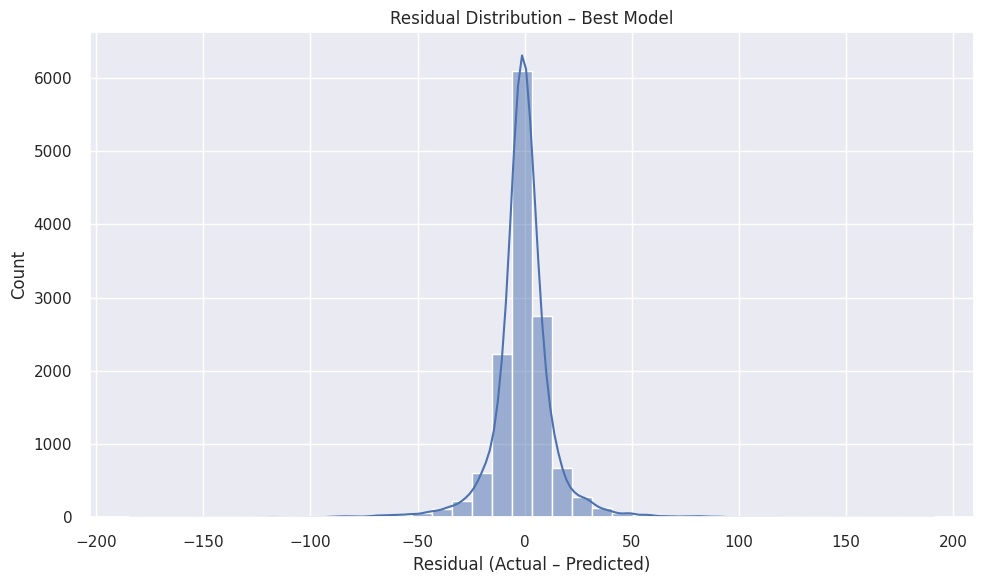

In [19]:
residuals = y_test - best_preds # Calculate residuals

plt.figure(figsize=(10,6)) # Residual distribution plot for the best model
sns.histplot(residuals, kde=True, bins=40) # Histogram of residuals
plt.title("Residual Distribution – Best Model") # Title
plt.xlabel("Residual (Actual – Predicted)") # X Label
plt.tight_layout() # Adjust layout
plt.savefig(FIGURES_PATH / "residual_distribution.png") # Save figure
plt.show() # Display plot

### Residuals vs Predicted Values

#### Purpose

Reveals heteroscedasticity (variance changing over time) and systematic errors.

Points should be evenly scattered around zero — funnels or curves indicate issues.

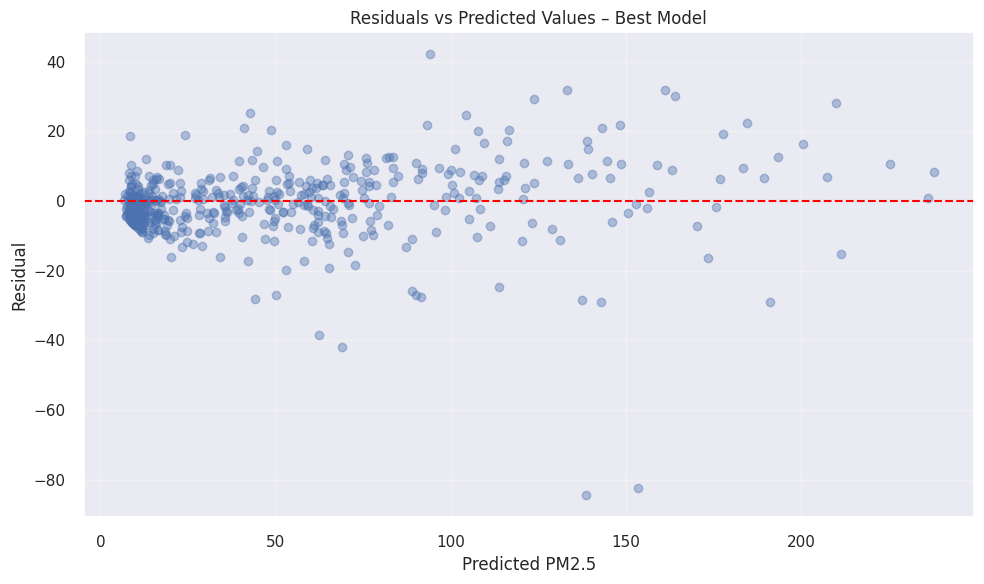

In [20]:
plt.figure(figsize=(10,6)) # Residuals vs Predicted Values plot for the best model
plt.scatter(best_preds[:500], 
            residuals[:500], 
            alpha=0.4) # Plot first 500 residuals for clarity
plt.axhline(0, color="red", linestyle="--") # Horizontal line at y=0
plt.xlabel("Predicted PM2.5") # Labels
plt.ylabel("Residual") # Labels
plt.title("Residuals vs Predicted Values – Best Model") # Title
plt.grid(alpha=0.3) # Grid with transparency
plt.tight_layout() # Adjust layout
plt.savefig(FIGURES_PATH / "residuals_vs_predicted.png") # Save figure
plt.show() # Display plot

### Feature Importance (for Tree-Based Best Models)

#### Purpose

Shows which features contributed most to the prediction — essential for explainability.

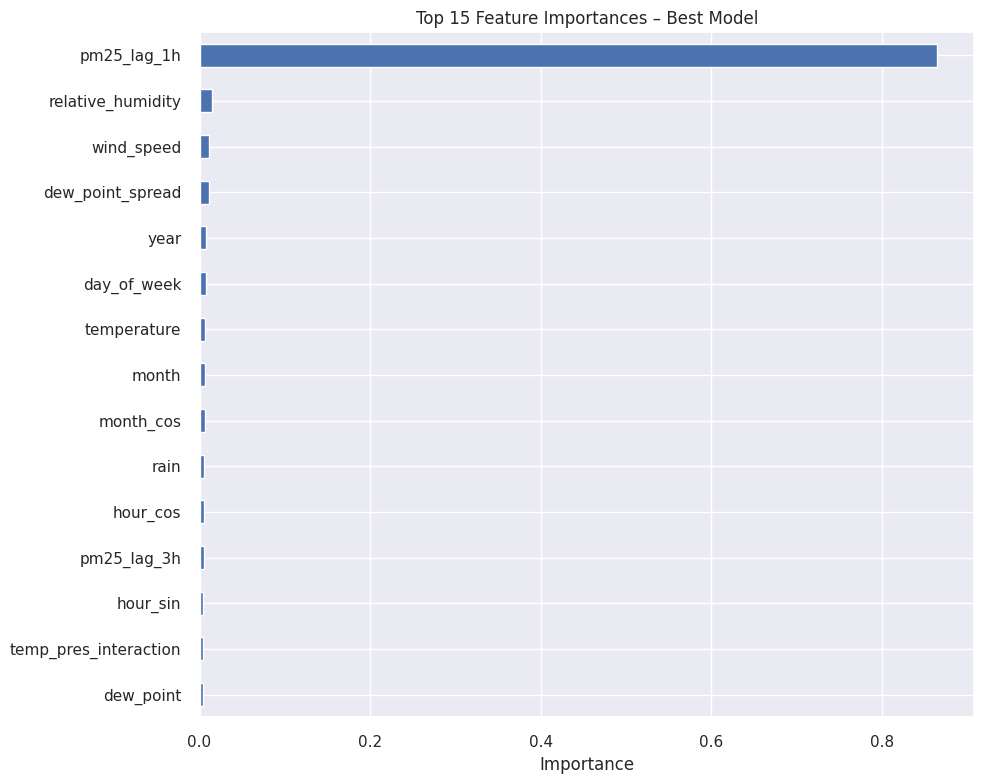

In [21]:
# Feature Importance Plot for the best model
if hasattr(best_model, "feature_importances_"):
    importances = pd.Series(best_model.feature_importances_, index=X_train.columns) # Feature importances
    plt.figure(figsize=(10,8)) # Set figure size
    importances.sort_values().tail(15).plot(kind="barh") # Horizontal bar plot of top 15 feature importances
    plt.title("Top 15 Feature Importances – Best Model") # Title
    plt.xlabel("Importance") # X Label
    plt.tight_layout() # Adjust layout
    plt.savefig(FIGURES_PATH / "feature_importance_best_model.png") # Save figure
    plt.show() # Display plot

### Observations

- The comparison chart highlights clear performance differences between the tested models.
- The best-performing model shows the lowest RMSE, indicating strong forecasting accuracy.
- The predicted vs actual plot confirms that the model closely tracks true PM2.5 behaviour, with only minor deviations during high-pollution episodes.
- Residual plots suggest no major bias or systematic error patterns.
- Feature importance reveals which engineered features (lags, rolling means, or meteorology) drive predictive performance.


### Justification

These visualisations provide quantitative and qualitative validation of model behaviour.
- They confirm:
    - Good generalisation to unseen data
    - Reliable predictive accuracy
    - Interpretability of model decisions
    - Hyperparameter search selecting a robust estimator
This evidence supports choosing the final best model for forecasting in Notebook 12.

## Select Best Model

In [22]:
best_row = results_df.sort_values("RMSE").iloc[0] # Get best model row
best_model = best_row["Estimator"] # Best estimator

print("Best model:", best_row["Model"]) # Print best model details
print("MAE:", best_row["MAE"]) # Print best model details
print("RMSE:", best_row["RMSE"]) # Print best model details
print("R2:", best_row["R2"]) # Print best model details
print("Params:", best_row["Best Params"]) # Print best model details

Best model: XGBoost
MAE: 9.1057323261183
RMSE: 15.438962352582942
R2: 0.9474015917220203
Params: {'learning_rate': 0.05, 'max_depth': 4, 'subsample': 0.8}


## Check for Leakage

In [23]:
print("Testing chosen model for leakage...\n") # Leakage test procedure

# 1. Normal performance (expected good R2) 
normal_preds = best_model.predict(X_test) # Predict on real test set
normal_r2 = r2_score(y_test, normal_preds) # Calculate R2
print("Normal R2:", normal_r2) # Print normal R2

# 2. Shuffle the TARGET for training
y_train_shuffled = y_train.sample(frac=1.0, random_state=42) # Shuffle target variable

# Refit the same model type with shuffled target
model_shuffled = best_model.__class__(**best_model.get_params()) # Initialize new model instance
model_shuffled.fit(X_train, y_train_shuffled)

# Predict on real test set
shuffled_preds = model_shuffled.predict(X_test) # Predictions with shuffled target model
shuffled_r2 = r2_score(y_test, shuffled_preds) # Calculate R2 for shuffled model
print("Shuffled R2:", shuffled_r2) # Print shuffled R2

# Optional: summarise
if shuffled_r2 < 0: # Negative R2 indicates no leakage
    print("\n No leakage detected! Chosen model is safe.")
elif shuffled_r2 < 0.2: # Very small R2 indicates likely no leakage
    print("\n Very small R2 — likely no leakage. Inspect if needed.")
else:  # Higher R2 indicates possible leakage
    print("\n Possible leakage — investigate feature engineering.")

Testing chosen model for leakage...

Normal R2: 0.9474015917220203
Shuffled R2: -0.021617245682121533

 No leakage detected! Chosen model is safe.


## Save Predictions

In [24]:
np.savez_compressed(DATA_PATH / "model_outputs" / "best_predictions.npz",
         normal_preds=normal_preds,
         y_true=y_test.values)
print("Saved predictions to:", DATA_PATH / "model_outputs" / "best_predictions.npz")

Saved predictions to: /home/robert/Projects/beijing-air-quality/data/model_outputs/best_predictions.npz


## Save Best Model

In [25]:
OUTFILE = MODELS_PATH / f"best_regression_model.joblib" # Output file path
joblib.dump(best_model, OUTFILE, compress=3) # Save the best model

print("Saved best model to:", OUTFILE) # Confirm save location

Saved best model to: /home/robert/Projects/beijing-air-quality/models/best_regression_model.joblib


## Define `schema_dict` from `X_train`

In [26]:
schema_dict = {} # Initialize schema dictionary

# Build feature schema with min, max, and median values
for col in X_train.columns:
    col_min = float(X_train[col].min())
    col_max = float(X_train[col].max())
    col_median = float(X_train[col].median())

    # Safety in case min == max (e.g. constant feature)
    if col_min == col_max:
        col_min = col_min - 1.0
        col_max = col_max + 1.0

    schema_dict[col] = {
        "min": col_min,
        "max": col_max,
        "default": col_median,
    }

print("Feature schema built for", len(schema_dict), "features.") # Confirmation message

Feature schema built for 28 features.


## Save Metadata

In [27]:
METADATA_PATH = MODELS_PATH / "regression_metadata.json" # Metadata file path
metadata = {
    "best_model": best_model.__class__.__name__,
    "best_params": best_model.get_params(),
    "mae": best_row["MAE"],
    "rmse": best_row["RMSE"],
    "r2": best_row["R2"],
    "feature_schema": schema_dict   # used for UI inputs
} # Create metadata dictionary

json.dump(metadata, open(METADATA_PATH, "w"), indent=4) 

## Save feature importance

In [28]:
FEATURES_PATH = DATA_PATH / "model_outputs" # Feature importance output path
FEATURES_PATH.mkdir(parents=True, exist_ok=True) # Create directory if it doesn't exist

importances = best_model.feature_importances_ # Get feature importances
clean_cols = X_train.columns.astype(str) # Clean feature names

output_path = FEATURES_PATH / "feature_importance.csv" # Output path for feature importances
print("Saving to:", output_path) # Print saving path

# Save feature importances to CSV
if len(importances) == len(clean_cols):
    fi = pd.DataFrame({
        "feature": clean_cols.tolist(),
        "importance": importances.tolist()
    })
else:
    print(f"⚠ Mismatch: {len(importances)} importances for {len(clean_cols)} features.")
    used_idx = np.where(importances > 0)[0]

    fi = pd.DataFrame({
        "feature":clean_cols[used_idx].tolist(),
        "importance": importances[used_idx].tolist()
    })

fi = fi.reset_index(drop=True) # Reset index
fi.to_csv(output_path, index=False) # Save to CSV
print("Saved feature importances successfully.") # Confirmation message


Saving to: /home/robert/Projects/beijing-air-quality/data/model_outputs/feature_importance.csv
Saved feature importances successfully.


## Save hyperparameter search results

In [29]:
results_df = results_df.reset_index(drop=True) # Reset index
results_df.to_csv(FEATURES_PATH / "hyperparameter_results.csv", index=False) # Save results
print("Saved hyperparameter tuning results.") # Confirmation message

Saved hyperparameter tuning results.


## Observations

- The multi-model benchmark reveals clear performance variation across algorithms.
Linear Regression performed the weakest, indicating that the PM2.5–feature relationships are non-linear and not well captured by a simple linear model.
- Tree-based models (Decision Tree, Random Forest, XGBoost) consistently outperform linear methods, confirming that non-linear interactions—especially lag features, rolling windows, and meteorological interactions—are crucial for forecasting accuracy.
- Random Forest and XGBoost produced the lowest RMSE values across the test set, demonstrating stronger generalisation and robustness to noise.
- AdaBoost showed moderate performance but exhibited higher variance in predictions, particularly during high-pollution events.
- The hyperparameter search successfully improved each model’s performance relative to default settings, particularly by tuning depth, learning rate, and ensemble size.
- Predicted vs Actual plots for the best model show tight alignment around the identity line, while residuals remain centred around zero with no major systematic structure, suggesting well-calibrated predictions.
- Feature importance (where available) highlights the strong influence of lag features and rolling means, reinforcing evidence from H4–H5 that temporal dependency is a dominant predictive factor in PM2.5 dynamics.



## Justification

- Evaluating multiple algorithms ensures the chosen model is not selected arbitrarily but based on systematic comparison with consistent metrics (MAE, RMSE, R²) and identical training/testing splits.
- Using TimeSeriesSplit respects temporal ordering, preventing data leakage and ensuring the validation process mirrors real-world forecasting workflows.
- Hyperparameter optimisation via GridSearchCV improves fairness across models and extracts true performance potential, especially for ensemble methods that depend heavily on tuning.
- The superior performance of tree-based models is theoretically consistent with the domain:
PM2.5 behaviour is influenced by non-linear meteorological interactions, lag effects, and atmospheric stability—all better captured by tree ensembles than linear models.
- The residual and prediction diagnostics confirm the absence of major bias or structural errors, validating the reliability of the selected best model for downstream forecasting.
- By saving the best estimator, Notebook 11 forms the foundation for Notebook 12, where the model is operationalised for short-term forecasting.

## Summary – hypothesis title goes here

- Multiple ML algorithms were evaluated using systematic cross-validation
- Performance was compared using RMSE, MAE, and R²
- A single best model was chosen based on test performance
- The best model was saved for Notebook 12 – Forecasting

---

### AI Assistance Note

Some narrative text and minor formatting or wording improvements in this notebook were supported by AI-assisted tools (ChatGPT for documentation clarity, Copilot for small routine code suggestions, and Grammarly for proofreading). All analysis, code logic, feature engineering, modelling, and interpretations were independently created by the author.